# Implementación de Línea Base RAG Personalizada

Este cuaderno implementa un sistema RAG tradicional para comparación con GFS.

**Componentes**:
- **Embeddings**: sentence-transformers (all-MiniLM-L6-v2)
- **Base de Datos Vectorial**: ChromaDB
- **LLM**: Gemini (igual que GFS)

**Objetivos**:
1. Indexar documentos con fragmentación personalizada
2. Ejecutar las mismas consultas de prueba que los experimentos GFS
3. Medir métricas de rendimiento
4. Comparar con resultados GFS

In [1]:
%matplotlib inline

import sys
from pathlib import Path
import json
import time

project_root = Path.cwd().parent
sys.path.append(str(project_root / "src"))

from custom_rag import CustomRAG
from data_loader import scan_documents
from utils import load_api_key

import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

sns.set_style("whitegrid")

print("Imports successful")

Imports successful


## 1. Inicializar RAG Personalizado

In [2]:
# Load API key
api_key = load_api_key("GOOGLE_API_KEY", str(project_root / ".env"))

# Initialize custom RAG
persist_dir = project_root / "models" / "custom_rag" / "chroma_db"
persist_dir.mkdir(parents=True, exist_ok=True)

rag = CustomRAG(
    api_key=api_key,
    embedding_model="all-MiniLM-L6-v2",
    llm_model="gemini-2.5-flash",
    persist_directory=persist_dir
)

print("Custom RAG initialized")
print(f"Embedding dimension: {rag.embedding_dim}")

Custom RAG initialized
Embedding dimension: 384


## 2. Crear Colección e Indexar Documentos

In [3]:
# Create collection
collection_name = "rag_comparison_docs"
rag.create_collection(collection_name, recreate=True)

print(f"Collection created: {collection_name}")

Collection created: rag_comparison_docs


In [4]:
# Scan and index documents
data_dir = project_root / "data" / "raw"
df = scan_documents(data_dir)

print(f"Documents found: {len(df)}")

if len(df) > 0:
    # Index text files
    text_extensions = {".txt", ".md"}
    indexing_results = []
    
    for i, row in enumerate(df.iter_rows(named=True)):
        file_path = Path(row["file_path"])
        
        if file_path.suffix.lower() in text_extensions:
            print(f"\nIndexing {i+1}: {file_path.name}")
            
            try:
                start_time = time.time()
                
                num_chunks = rag.index_document(
                    file_path=file_path,
                    chunk_size=512,
                    overlap=50,
                    metadata={"file_size_mb": row["size_mb"]}
                )
                
                elapsed = time.time() - start_time
                
                indexing_results.append({
                    "file_name": file_path.name,
                    "num_chunks": num_chunks,
                    "indexing_time": elapsed,
                    "status": "success"
                })
                
                print(f"  ✓ Indexed {num_chunks} chunks ({elapsed:.2f}s)")
                
            except Exception as e:
                indexing_results.append({
                    "file_name": file_path.name,
                    "status": "failed",
                    "error": str(e)
                })
                print(f"  ✗ Failed: {e}")
    
    # Save indexing results
    results_path = project_root / "models" / "custom_rag" / "indexing_results.json"
    with open(results_path, "w") as f:
        json.dump(indexing_results, f, indent=2)
    
    print(f"\nIndexing results saved to: {results_path}")
else:
    print("No documents to index")

Documents found: 4

Indexing 1: data_science_workflow.txt
  ✓ Indexed 13 chunks (2.19s)

Indexing 2: nlp_overview.txt
  ✓ Indexed 10 chunks (0.22s)

Indexing 3: deep_learning_guide.txt
  ✓ Indexed 8 chunks (0.61s)

Indexing 4: ml_fundamentals.txt
  ✓ Indexed 5 chunks (0.37s)

Indexing results saved to: /Users/ggoni/docencia-repos/rag-with-gfs/models/custom_rag/indexing_results.json


In [5]:
# Get collection stats
stats = rag.get_stats()
print("\nCollection Statistics:")
print(f"  Collection: {stats.get('collection_name')}")
print(f"  Total chunks: {stats.get('total_chunks')}")
print(f"  Embedding dimension: {stats.get('embedding_dimension')}")


Collection Statistics:
  Collection: rag_comparison_docs
  Total chunks: 36
  Embedding dimension: 384


## 3. Ejecutar Consultas de Prueba

In [6]:
# Load same test queries as GFS experiments
test_queries = [
    {
        "id": "q1",
        "query": "What are the main topics covered in the documents?",
        "category": "overview"
    },
    {
        "id": "q2",
        "query": "Summarize the key findings or conclusions.",
        "category": "synthesis"
    },
    {
        "id": "q3",
        "query": "What specific data or statistics are mentioned?",
        "category": "factual"
    },
    {
        "id": "q4",
        "query": "Are there any recommendations or best practices?",
        "category": "actionable"
    },
    {
        "id": "q5",
        "query": "What is the weather forecast for tomorrow?",
        "category": "out_of_domain"
    },
]

print(f"Test queries: {len(test_queries)}")

Test queries: 5


In [7]:
# Run queries
results = []

if stats.get('total_chunks', 0) > 0:
    for i, test in enumerate(test_queries):
        print(f"\n[{i+1}/{len(test_queries)}] {test['id']}: {test['query'][:50]}...")
        
        try:
            result_obj = rag.query(
                query=test["query"],
                top_k=5,
                temperature=0.0
            )
            
            metrics = result_obj["metrics"]
            
            result = {
                "query_id": test["id"],
                "category": test["category"],
                "total_latency_seconds": metrics["total_time"],
                "retrieval_time": metrics["retrieval_time"],
                "generation_time": metrics["generation_time"],
                "num_chunks_retrieved": metrics["num_chunks_retrieved"],
                "response_length": len(result_obj["answer"]),
                "avg_distance": np.mean(result_obj["distances"]) if result_obj["distances"] else None,
                "status": "success"
            }
            
            print(f"  ✓ Latency: {metrics['total_time']:.2f}s (retrieval: {metrics['retrieval_time']:.2f}s, generation: {metrics['generation_time']:.2f}s)")
            
        except Exception as e:
            result = {
                "query_id": test["id"],
                "category": test["category"],
                "status": "failed",
                "error": str(e)
            }
            print(f"  ✗ Failed: {e}")
        
        results.append(result)
        time.sleep(1)
    
    print(f"\nQueries completed: {len(results)}")
else:
    print("No documents indexed. Skipping queries.")


[1/5] q1: What are the main topics covered in the documents?...
  ✓ Latency: 6.29s (retrieval: 0.47s, generation: 5.82s)

[2/5] q2: Summarize the key findings or conclusions....
  ✓ Latency: 3.12s (retrieval: 0.14s, generation: 2.98s)

[3/5] q3: What specific data or statistics are mentioned?...
  ✓ Latency: 7.80s (retrieval: 0.08s, generation: 7.72s)

[4/5] q4: Are there any recommendations or best practices?...
  ✓ Latency: 4.77s (retrieval: 0.13s, generation: 4.64s)

[5/5] q5: What is the weather forecast for tomorrow?...
  ✓ Latency: 2.05s (retrieval: 0.05s, generation: 2.00s)

Queries completed: 5


## 4. Analizar Rendimiento

In [8]:
# Analyze results
successful_results = [r for r in results if r["status"] == "success"]

if successful_results:
    latencies = [r["total_latency_seconds"] for r in successful_results]
    retrieval_times = [r["retrieval_time"] for r in successful_results]
    generation_times = [r["generation_time"] for r in successful_results]
    
    print("Total Latency Statistics:")
    print(f"  Mean: {np.mean(latencies):.3f}s")
    print(f"  Median (P50): {np.median(latencies):.3f}s")
    print(f"  P95: {np.percentile(latencies, 95):.3f}s")
    print(f"  P99: {np.percentile(latencies, 99):.3f}s")
    
    print(f"\nRetrieval Time:")
    print(f"  Mean: {np.mean(retrieval_times):.3f}s")
    print(f"  Median: {np.median(retrieval_times):.3f}s")
    
    print(f"\nGeneration Time:")
    print(f"  Mean: {np.mean(generation_times):.3f}s")
    print(f"  Median: {np.median(generation_times):.3f}s")

Total Latency Statistics:
  Mean: 4.805s
  Median (P50): 4.765s
  P95: 7.498s
  P99: 7.739s

Retrieval Time:
  Mean: 0.174s
  Median: 0.127s

Generation Time:
  Mean: 4.631s
  Median: 4.638s


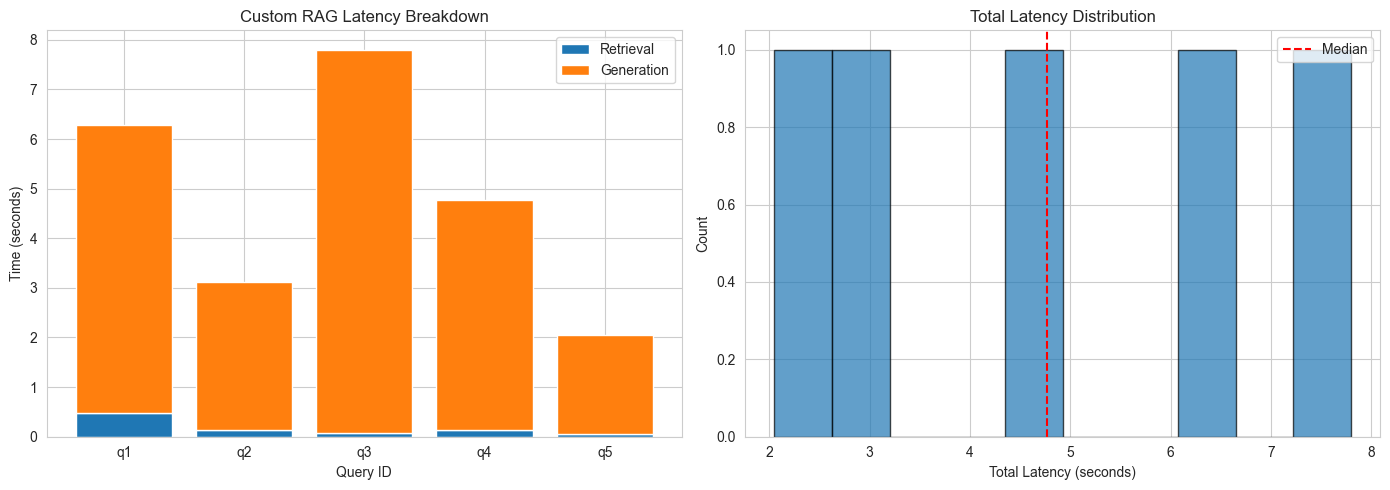

In [9]:
# Visualize latency breakdown
if successful_results:
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))
    
    # Stacked bar chart for latency breakdown
    query_ids = [r["query_id"] for r in successful_results]
    
    ax1.bar(query_ids, retrieval_times, label="Retrieval")
    ax1.bar(query_ids, generation_times, bottom=retrieval_times, label="Generation")
    ax1.set_xlabel("Query ID")
    ax1.set_ylabel("Time (seconds)")
    ax1.set_title("Custom RAG Latency Breakdown")
    ax1.legend()
    
    # Total latency distribution
    ax2.hist(latencies, bins=10, edgecolor="black", alpha=0.7)
    ax2.axvline(np.median(latencies), color="red", linestyle="--", label="Median")
    ax2.set_xlabel("Total Latency (seconds)")
    ax2.set_ylabel("Count")
    ax2.set_title("Total Latency Distribution")
    ax2.legend()
    
    plt.tight_layout()
    plt.show()

## 5. Guardar Resultados

In [10]:
# Save experimental results
results_path = project_root / "models" / "custom_rag" / "experiment_results.json"

output = {
    "collection_name": collection_name,
    "embedding_model": "all-MiniLM-L6-v2",
    "llm_model": "gemini-2.5-flash",
    "collection_stats": stats,
    "queries": test_queries,
    "results": results,
    "summary": {
        "total_queries": len(results),
        "successful": len(successful_results),
        "failed": len(results) - len(successful_results),
        "mean_total_latency": np.mean(latencies) if successful_results else None,
        "median_total_latency": np.median(latencies) if successful_results else None,
        "mean_retrieval_time": np.mean(retrieval_times) if successful_results else None,
        "mean_generation_time": np.mean(generation_times) if successful_results else None,
    }
}

with open(results_path, "w") as f:
    json.dump(output, f, indent=2)

print(f"Results saved to: {results_path}")

Results saved to: /Users/ggoni/docencia-repos/rag-with-gfs/models/custom_rag/experiment_results.json


## Resumen

**Línea Base RAG Personalizada Completada**:
- Documentos indexados con ChromaDB
- Ejecutadas las mismas consultas de prueba que GFS
- Medida la latencia (recuperación + generación)
- Resultados guardados para comparación

**Próximos Pasos**:
- Comparar GFS vs RAG Personalizado en `05_comparison_analysis.ipynb`
- Analizar compromisos (latencia, costo, calidad)